This notebook is used to cluster the features.

In [11]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('bmh')
mpl.rcParams.update({
    "grid.linestyle" : "dashed",
    "grid.alpha" : 0,
    "axes.facecolor" : "white",
    "axes.spines.top" : False,
    "axes.spines.bottom" : False,
    "axes.spines.right" : False,
    "axes.spines.left" : False,
    "legend.frameon" : False,
    "figure.figsize" : (8, 5),
    "figure.dpi" : 500,
})

%matplotlib inline
pd.set_option('display.max_colwidth', None)


In [12]:
suffix_old = ""
suffix = ""

n_features = 18
path_thyroid = "data/thyroid/"
path_without_thyroid = "data/no_thyroid/"
path = path_without_thyroid if n_features == 18 else path_thyroid
dataset = "data_without_thyroid.csv" if n_features == 18 else "data_with_thyroid.csv"
path_results = f"{path}results/"
path_dataset = f"{path}{dataset}"
path_models = f"models/{n_features}features/"
path_images = f"figures/{n_features}features/"

In [13]:
# Load the dataset without the target feature
df = pd.read_csv(path_dataset, index_col=0, decimal='.')
df = df.iloc[:, :-1]

### Feature Clustering Using Correlation Matrix

In [14]:
corr = df.corr(method='pearson').abs()
threshold = 0.3
df_cluster = pd.DataFrame()

# For each column we sort the column's and get the top correlated columns by setting a threshold,
# and save the result in a df
for col_name in corr.columns:
    corr_col = corr[col_name].sort_values(ascending=False)
    corr_col = corr_col[corr_col >= threshold]
    
    corr_series = pd.DataFrame([",".join(corr_col.index.values)], index=[col_name], columns=["correlated_columns"])
    df_cluster = df_cluster.append(corr_series)
    # print(corr_series.index.values[0])
    # print(corr_series.values[0][0])
    # print("\n")

# df_cluster.to_csv(f"data/data/features_clustering/feat_cluster_{threshold}.csv")
df_cluster.head()

/var/folders/qs/rp0hmt3d4fx9p428q25v2k600000gn/T/ipykernel_98467/1540370341.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cluster = df_cluster.append(corr_series)
/var/folders/qs/rp0hmt3d4fx9p428q25v2k600000gn/T/ipykernel_98467/1540370341.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cluster = df_cluster.append(corr_series)
/var/folders/qs/rp0hmt3d4fx9p428q25v2k600000gn/T/ipykernel_98467/1540370341.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cluster = df_cluster.append(corr_series)
/var/folders/qs/rp0hmt3d4fx9p428q25v2k600000gn/T/ipykernel_98467/1540370341.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead

,correlated_columns
Gender (Male = 1),Gender (Male = 1)
Age,Age
Angina,"Angina,Documented resting \nor exertional ischemia,Angiography,Vessels"
Previous CABG,"Previous CABG,Vessels"
Previous PCI,"Previous PCI,Previous Myocardial Infarction"


Correlation (>= 0.3) size: 17.0 / 272


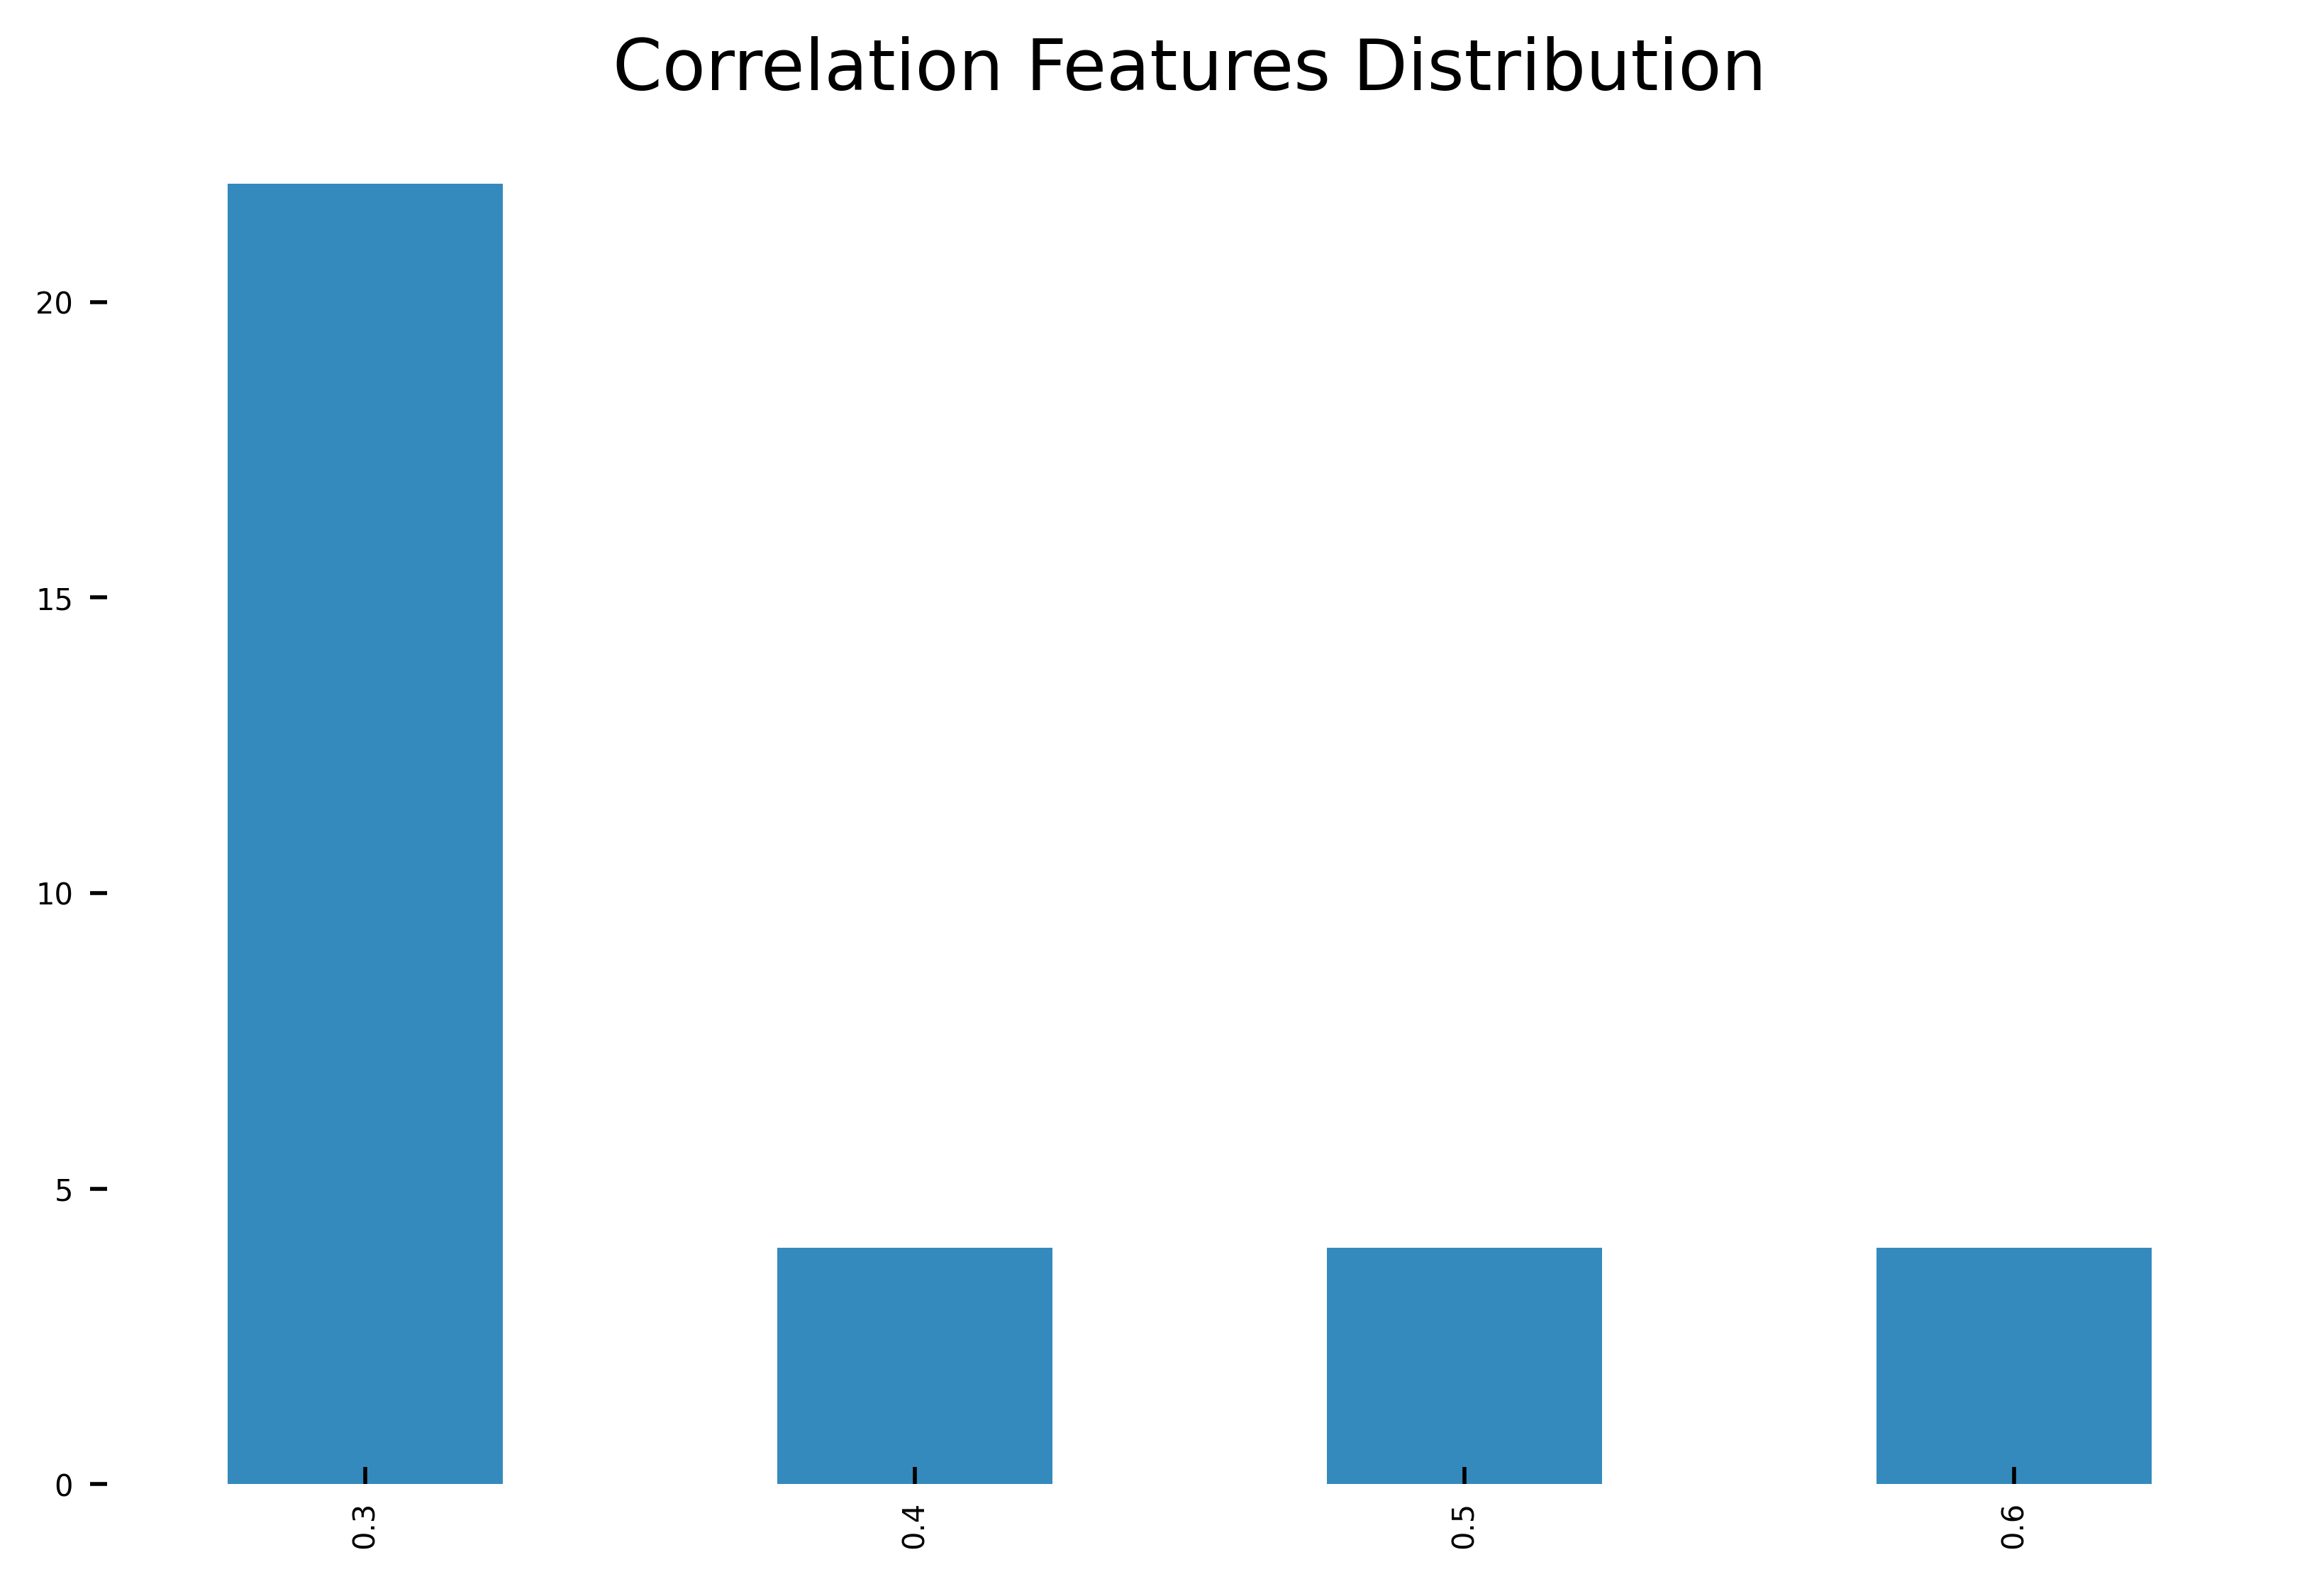

In [15]:
corr1D = pd.Series(corr.values.flatten())
corr1D = corr1D[corr1D != 1]
corr1D = corr1D.map(lambda x: round(x, 1))
corr_dist = corr1D.value_counts().sort_index()
corr_dist = corr_dist[corr_dist.index >= threshold]
corr_dist.plot(kind="bar", fontsize=6)
plt.title("Correlation Features Distribution")

print(f"Correlation (>= {threshold}) size: {corr_dist[corr_dist.index >= threshold].sum()/2} / {len(corr1D/2)}")

### Feature Clustering Using Correlation Matrix + Hierarchical Clustering
[Clustering using a matrix of correlation coeff](https://stackoverflow.com/questions/38070478/how-to-do-clustering-using-the-matrix-of-correlation-coefficients)

[S v P](https://stats.stackexchange.com/questions/8071/how-to-choose-between-pearson-and-spearman-correlatio) considerations
- Spearman checks only the monotonic relationships (less assumptions, more resistant to outliers)
- Pearson checks the linear relationships

In [6]:
df.columns

Index(['Gender (Male = 1)', 'Age', 'Angina', 'Previous CABG', 'Previous PCI',
       'Previous Myocardial Infarction', 'Acute Myocardial Infarction',
       'Angiography', 'Vessels', 'Documented resting \nor exertional ischemia',
       'Post-ischemic Dilated\nCardiomyopathy', 'Smoke\nHistory of smoke',
       'Diabetes\nHistory of diabetes',
       'Hypertension\nHistory of hypertension',
       'Dyslipidemia\nHystory of dyslipidemia', 'Atrial Fibrillation', 'fe'],
      dtype='object')

In [7]:
df = df.rename(columns={
    "Smoke\nHistory of smoke": "Smoke",
    "Diabetes\nHistory of diabetes": "Diabetes",
    "Hypertension\nHistory of hypertension": "Hypertension",
    "Dyslipidemia\nHystory of dyslipidemia": "Dyslipidemia",
    "fe": "LVEF",
    "Gender (Male = 1)": "Gender",
    "Previous Myocardial Infarction": "Previous MI",
    "Previous PCI": "PCI",
    "Acute Myocardial Infarction": "Acute MI",
    "Post-ischemic Dilated\nCardiomyopathy": "Post IDC",
})

Number of clusters: 5


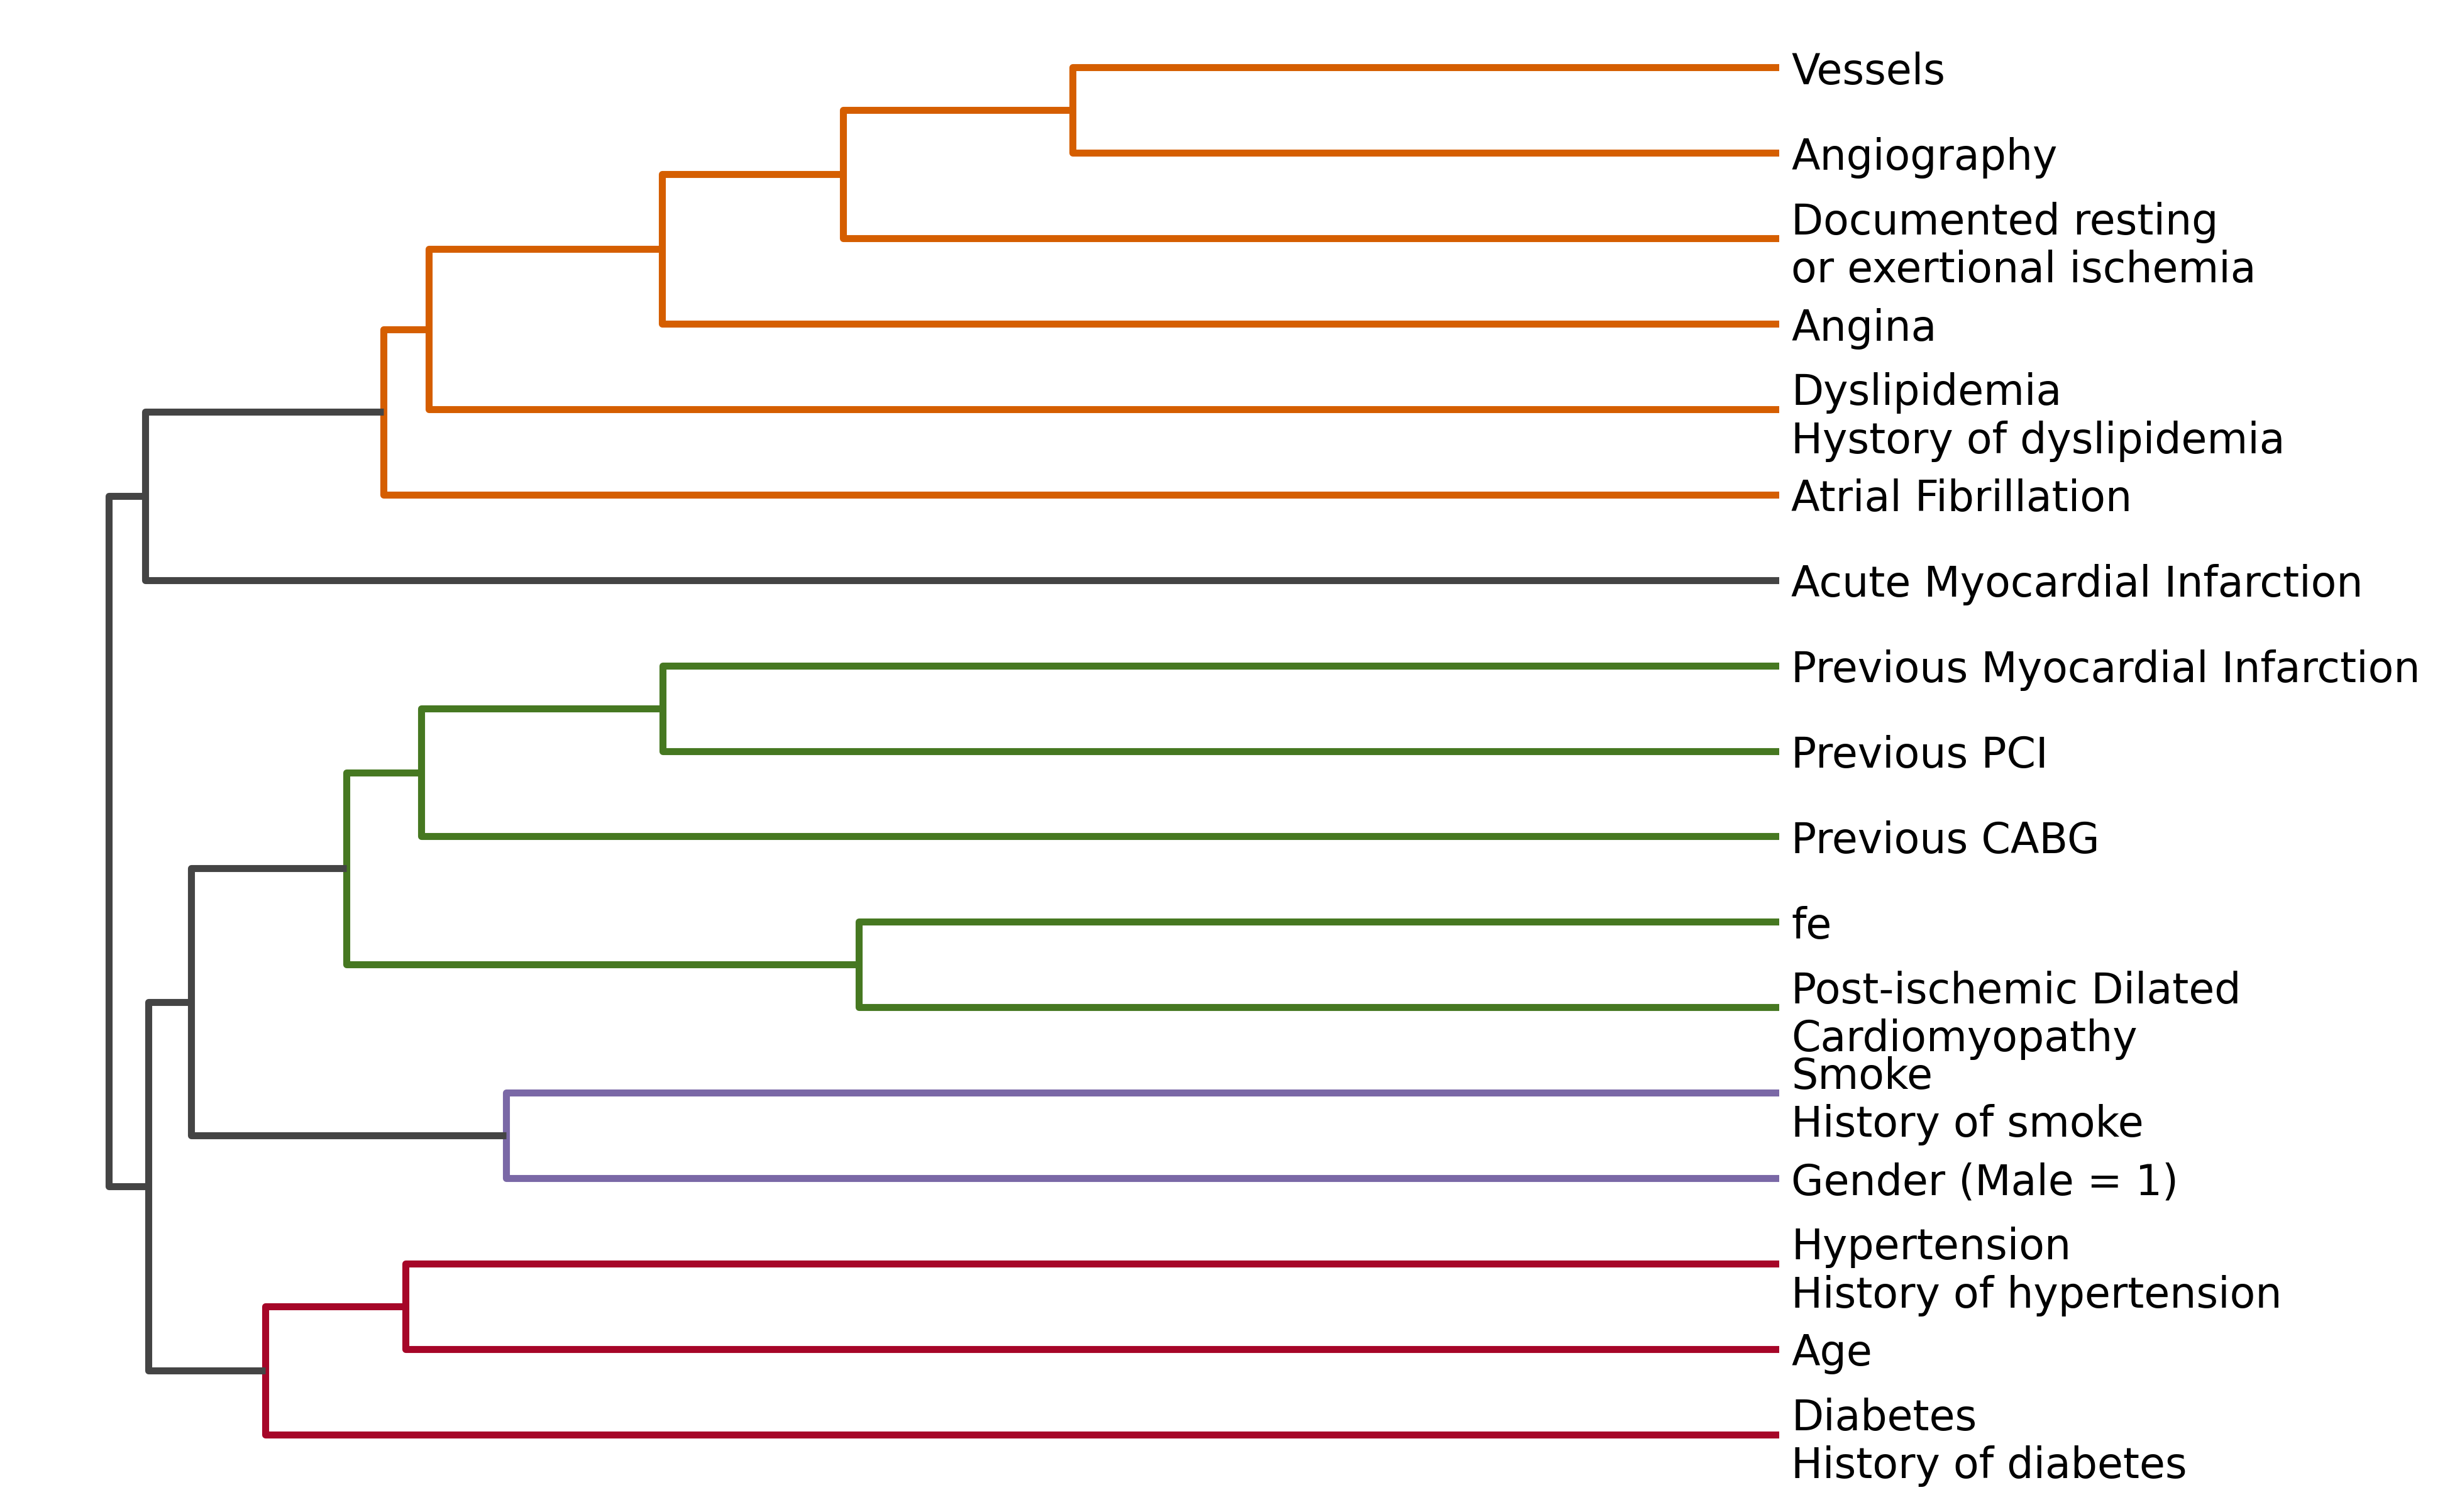

In [16]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform

# 1) Compute the correlation (similarity) and distance (dissimilarity)
corr = df.corr(method="spearman")  
dist = 1 - corr.abs()

# 2) Transform the distance matrix into a condensed distance vector
dist_condense = pdist(dist)

# 3) Create the hierarchical clustering using the condensend distance vector
hier = hierarchy.linkage(dist_condense, method="weighted")
threshold = 1.3
cluster_labels = hierarchy.fcluster(hier, threshold, criterion="distance")
print(f"Number of clusters: {len(set(cluster_labels))}")

# Plot
# Choose threshold using dendrogram or any other method (e.g. quantile or desired number of features)
plt.figure(figsize=(9, 7.5), dpi=400)
# plt.title("Hierarchy Clustering of Features")
plt.tick_params(labelbottom=False, bottom=False)
dend = hierarchy.dendrogram(
    hier, 
    truncate_mode="level", 
    p=30, 
    color_threshold=threshold, 
    above_threshold_color='#444444',
    labels=corr.columns, 
    orientation="left", 
    leaf_font_size=12
)
plt.savefig(f"./{path_images}cluster.tiff", format="tiff", dpi=400, bbox_inches="tight")

In [17]:
# Save each group feature
df_cluster = pd.DataFrame({'ClusterID': cluster_labels,
                           'Feature': df.columns})
df_cluster = df_cluster.groupby(['ClusterID'])
df_cluster = df_cluster['Feature'].apply(lambda x: list(x)).reset_index()['Feature']
df_cluster.to_pickle(f'{path_results}feat_cluster_hier.df')

In [10]:
from scipy.cluster.hierarchy import cophenet
from sklearn.metrics import silhouette_score
# Cophenet correlation measure how faithfully the dendrogram preserves the original data point's distance
# Cophenet = optimal when -> 1
# https://en.wikipedia.org/wiki/Cophenetic_correlation
c, coph_dists = cophenet(hier, pdist(dist))
c

0.8433821274948674